In [1]:
import pandas as pd 
import numpy as np
import time
import re
from sklearn.feature_extraction.text import CountVectorizer
import pickle
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression, Perceptron
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import f1_score, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import learning_curve
from sklearn.metrics import classification_report, roc_auc_score, matthews_corrcoef
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.svm import LinearSVC,SVR
from sklearn.feature_selection import RFECV
from sklearn.calibration import CalibratedClassifierCV
from sklearn.preprocessing import Binarizer
import matplotlib.pyplot as plt
from sklearn.calibration import calibration_curve

In [2]:
# java_stop_words = stopwords.words('english')
stop_words = ['testing', 'fuc', 'test','public','void','country', 'class', 'tests', 'atomic','ca','bs', 'dc']
# java_stop_words.extend(custom_words)

def clean_words(text):
    res = re.findall(r'\b\w+\b', text)
    return res

def remove_stopwords(text):
    text = str(text).lower().strip()
    tokens = []
    for token in text:
        if token not in stop_words:
            tokens.append(token)
            
    return "".join(tokens)


In [3]:
def remove_comments(text):
    no_comments = re.sub(r'#.*', '', text)
    no_comments = re.sub(r'/\*.*\/\*', '', no_comments)
    no_comments = re.sub(r'\d+','',no_comments)
    no_comments = re.sub(r'_', ' ', no_comments)
    return no_comments

def remove_cammel(text):
    no_cammel = re.sub('([A-Z][a-z]+)', r' \1', re.sub('([A-Z]+)', r' \1', text)).lower().split()
    return no_cammel

In [4]:
# def init_dataset(filename, language):
#     data = pd.read_excel(filename)
#     df = pd.DataFrame(data, columns=['Language', 'project name', 'test case name', 'label','test case content', 'tokens'])
    

In [5]:
#init dataset
data = pd.read_excel('./flaky_data.xlsx')
df = pd.DataFrame(data, columns=['Language', 'project name', 'test case name', 'label','test case content', 'tokens'])
df.drop('project name', axis=1, inplace=True)
df.drop('test case name', axis=1, inplace=True)


#remove comments

df['test case content'] = df['test case content'].apply(lambda x: remove_comments(x))
df['test case content'] = df['test case content'].apply(lambda x: remove_cammel(x))
# df['test case content'] = df['test case content'].apply(lambda x: clean_words(x))
df['tokens'] = df['test case content']



In [6]:
#filter python data and tokenize
java_df = df[df['Language'] == 'go']
go_df = java_df.reset_index(drop=True)

tokenizer = CountVectorizer(analyzer='word', max_features=1500,stop_words=stop_words)

    
go_df.tokens = go_df.tokens.apply(lambda x: remove_stopwords(x))
bow_token = tokenizer.fit_transform(go_df.tokens)

bow_data = pd.DataFrame(bow_token.toarray(), columns=tokenizer.get_feature_names_out())

#save the vocabulary to extract features on "production"

pickle.dump(tokenizer.vocabulary_, open("./vocabulary/python.dict", 'wb'))


In [7]:
print(list(tokenizer.vocabulary_))

['add', 'int', 'connect', 'attempts', 'load', 'if', 'return', 'fmt', 'errorf', 'error', 'nil', 'func', 'manifest', 'files', 'are', 'equal', 'var', 'struct', 'description', 'string', 'pod', 'yamls', 'expected', 'result', 'bool', 'diff', 'expect', 'err', 'manifests', 'valid', 'true', 'false', 'ignore', 'different', 'fields', 'order', 'with', 'not', 'image', 'gcr', 'io', 'google', 'containers', 'etcd', 'amd', 'for', 'adding', 'new', 'defaults', 'invalid', 'default', 'restart', 'policy', 'always', 'first', 'doesn', 'exist', 'second', 'rt', 'range', 'run', 'tmpdir', 'testutil', 'setup', 'temp', 'dir', 'defer', 'os', 'remove', 'all', 'write', 'path', 'filepath', 'join', 'strconv', 'itoa', 'yaml', 'file', 'byte', 'fatalf', 'failed', 'to', 'tfatal', 'compare', 'them', 'actual', 'nexpected', 'nactual', 'texpected', 'tgot', 'tactual', 'strings', 'contains', 'should', 'timeout', 'plugin', 'client', 'time', 'millisecond', 'fake', 'dra', 'driver', 'grpc', 'server', 'manager', 'clock', 'sleep', 'fas

In [8]:
go_df.drop('tokens', axis=1, inplace=True)
go_df.drop('test case content', axis=1, inplace=True)
go_df.drop('Language', axis=1, inplace=True)
go_df.reset_index()
# java_df.dropna(inplace=True)



,index,label
0,0,Flaky
1,1,Flaky
2,2,Flaky
3,3,Flaky
4,4,Flaky
...,...,...
85,85,NonFlaky
86,86,NonFlaky
87,87,NonFlaky
88,88,NonFlaky


In [9]:

y = go_df.label.copy()
go_df = pd.concat([go_df, bow_data], axis=1)


In [10]:
go_df = go_df.drop('label', axis=1)
x = go_df

In [11]:
# split train test data
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.20, random_state=1)


In [12]:
#init classifiers

classifiers = {
    'randomForest': RandomForestClassifier(random_state=1),
    'decisionTree': DecisionTreeClassifier(min_samples_leaf=1),
    'naiveBayes': GaussianNB(),
    'smo': CalibratedClassifierCV(LinearSVC(fit_intercept=False, tol=0.001, C=1, dual=False, max_iter=100000), method='sigmoid'),
    'knn': KNeighborsClassifier(n_neighbors=1, metric='euclidean'),
    'logisticRegression': LogisticRegression(max_iter=1000),
    'perceptron': CalibratedClassifierCV(Perceptron()),
    'lda': LinearDiscriminantAnalysis(),
}

In [13]:
def save_incorrect_classifications(x_test, predicted, label, classifier):
    label = label.to_frame(name='labeltestclass').reset_index()
    predicted = pd.DataFrame(predicted, columns=['predictedclass']).reset_index()
    
    df = pd.DataFrame(x_test).reset_index()
    df['labeltestclass'] = label.reset_index()['labeltestclass']
    df['predictedclass'] = predicted.reset_index()['predictedclass']
    
    df[df.predictedclass != df.labeltestclass].to_csv("./IC/"+classifier+"_IC.txt")


def round_float(value):
    return float("{:.3f}".format(value))


def get_time(start_time):
    end_time = time.time()
    return end_time - start_time


def plot_learning_curve(estimator, name, title, x,y, axes=None, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    
    if axes is None:
        fig, axes = plt.subplots(1, 3, figsize=(30, 7))
        
    axes[0].set_title(title)
    
    if ylim is not None:
        axes[0].set_ylim(*ylim)
        
    axes[0].set_xlabel("Training examples")
    axes[0].set_ylabel("Score")
    
    train_sizes, train_scores, test_scores, fit_times, _ = \
        learning_curve(estimator, x, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes, return_times=True)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.mean(test_scores, axis=1)
    fit_times_mean = np.mean(fit_times, axis=1)
    fit_times_std = np.std(fit_times, axis=1)
    
    # plot learning curve
    axes[0].grid()
    axes[0].fill_between(train_sizes, train_scores_mean - train_scores_std,
                         train_scores_mean + train_scores_std, alpha=0.1, color='r')
    axes[0].fill_between(train_sizes, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1, color='g')
    axes[0].plot(train_sizes, train_scores_mean, 'o-', color='r', label='training score')
    axes[0].plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")
    axes[0].legend(loc="best")
    
    # plot n_samples vs fit_times
    axes[1].grid()
    axes[1].plot(train_sizes, fit_times_mean, 'o-')
    axes[1].fill_between(train_sizes, fit_times_mean - fit_times_std, fit_times_mean + fit_times_std, alpha=0.1)
    axes[1].set_xlabel("Training examples")
    axes[1].set_ylabel("fit_times")
    axes[1].set_title("Scalability of the model")
    
    #plot fit_time vs score
    axes[2].grid()
    axes[2].plot(fit_times_mean, test_scores_mean, 'o-')
    axes[2].fill_between(fit_times_mean, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.1)
    axes[2].set_xlabel("fit_times")
    axes[2].set_ylabel("Score")
    axes[2].set_title("Performance of the model")
    
    fig.savefig('./plot' + name + '.png')            
    

In [14]:
def plot_comparison(comparison_values):
    
    comp = plt.figure(figsize=(10, 10))
    ax1 = plt.subplot2grid((3, 1), (0, 0), rowspan=2)
    ax2 = plt.subplot2grid((3, 1), (2, 0))

    for key, classifier in comparison_values.items():
        fraction_of_positives, mean_predicted_value = calibration_curve(classifier['y_test'], classifier['y_probs'], n_bins=10)
        ax1.plot(mean_predicted_value, fraction_of_positives, "s-",label="%s" % (key))
        ax2.hist(classifier['y_probs'], range=(0, 1), bins=10, label=key, histtype="step", lw=2)

    ax1.set_ylabel("Fraction of positives")
    ax1.set_ylim([-0.05, 1.05])
    ax1.legend(loc="lower right")
    ax1.set_title('Calibration plots  (reliability curve)')        

    ax2.set_xlabel("Mean predicted value")
    ax2.set_ylabel("Count")
    ax2.legend(loc="upper center", ncol=2)

    comp.tight_layout()
    
    comp.savefig('./plot/compare.png')

In [15]:
def classify(x_train, x_test, y_train, y_test, classifiers, normalize=[], plot=True):
    
    labels = ['Flaky', 'NonFlaky']
    results = pd.DataFrame()
    
    comparison_values = {}
    
    # create a normalized version
    train_scaler = Binarizer(threshold=0.0,).fit(x_train)
    test_scaler = Binarizer(threshold=0.0).fit(x_test)
    x_train_norm = train_scaler.transform(x_train)
    x_test_norm = test_scaler.transform(x_test)
    
    for key, classifier in classifiers.items():
        
        x_train_exec = x_train 
        x_test_exec = x_test
        y_train_exec = y_train
        y_test_exec = y_test
        
        if (key in normalize):
            x_train_exec = x_train_norm
            x_test_exec = x_test_exec
        
        classifier.fit(x_train_exec, y_train)
        classifier.score(x_test_exec, y_test)
        
        predict = classifier.predict(x_test_exec)
        y_probs = classifier.predict_proba(x_test_exec)[:,1]
        
        save_incorrect_classifications(x_test_exec, predict, y_test, key)
        
        result = {
            'classifier': key,
            'f1score': f1_score(y_test, predict, average='weighted'),
            'accuracy': classifier.score(x_test_exec, y_test),
            'confusionMatrix': confusion_matrix(y_test, predict),
            'execution': round_float(get_time(start_time)),
            'classificationReport': classification_report(y_test, predict, output_dict=True),
            'AUC': roc_auc_score(y_test, y_probs),
            'MCC': matthews_corrcoef(y_test, predict),
            
        }
        # results = pd.concat([results, result], ignore_index=True)
        results = results._append(result, ignore_index=True)
        
        
        if (plot):
            plot_learning_curve(classifier, key, key, x_train_exec, y_train, ylim=(0.5, 1.01), n_jobs=4)
            
            comparison_values[key] = {
                'y_test': y_test,
                'Y_probs': y_probs
            }

        
        print(key, classification_report(y_test, predict, output_dict=True)['Flaky'], matthews_corrcoef(y_test, predict), roc_auc_score(y_test, y_probs), "\n \n")

        res = [key, classification_report(y_test, predict, output_dict=True)['Flaky'], matthews_corrcoef(y_test, predict), roc_auc_score(y_test, y_probs)]
    
        classifications = classification_report(y_test, predict, output_dict=True)['Flaky']
    
    return results, res, classifications

In [16]:
def feature_ranking (X, y): 

    estimator = SVR(kernel="linear")
    selector = RFECV(estimator, step=5, cv=5, n_jobs=4)

    selector = selector.fit(X, y)

    return selector.ranking_,selector.score

def feature_importance(x, y):
    
    train_scaler = Binarizer(threshold=0.0,).fit(x_train)
    test_scaler = Binarizer(threshold=0.0).fit(x_test)
    x_train_norm = train_scaler.transform(x_train)
    x_test_norm = test_scaler.transform(x_test)
    estimator = RandomForestClassifier()
    estimator.fit(x, y)
    importance = estimator.feature_importances_
    
    return importance

randomForest {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 2.0} 1.0 1.0 
 

decisionTree {'precision': 0.6666666666666666, 'recall': 1.0, 'f1-score': 0.8, 'support': 2.0} 0.7905694150420948 0.96875 
 

naiveBayes {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 2.0} 1.0 1.0 
 



/Users/xinsu99/Desktop/RENE/workshop/ENV/lib/python3.11/site-packages/sklearn/model_selection/_split.py:737: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(
/Users/xinsu99/Desktop/RENE/workshop/ENV/lib/python3.11/site-packages/sklearn/model_selection/_split.py:737: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(
/Users/xinsu99/Desktop/RENE/workshop/ENV/lib/python3.11/site-packages/sklearn/model_selection/_split.py:737: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
/Users/xinsu99/Desktop/RENE/workshop/ENV/lib/python3.11/site-packages/sklearn/model_selection/_split.py:737: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/Users/xinsu99/Desktop/RENE/workshop/ENV/lib/python3.11/site-packages/sklearn/model_selection/_split.py:737: UserWar

smo {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 2.0} 1.0 1.0 
 



/Users/xinsu99/Desktop/RENE/workshop/ENV/lib/python3.11/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but KNeighborsClassifier was fitted without feature names
  warnings.warn(
/Users/xinsu99/Desktop/RENE/workshop/ENV/lib/python3.11/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but KNeighborsClassifier was fitted without feature names
  warnings.warn(
/Users/xinsu99/Desktop/RENE/workshop/ENV/lib/python3.11/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but KNeighborsClassifier was fitted without feature names
  warnings.warn(
/Users/xinsu99/Desktop/RENE/workshop/ENV/lib/python3.11/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but KNeighborsClassifier was fitted without feature names
  warnings.warn(


knn {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 2.0} 1.0 1.0 
 

logisticRegression {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 2.0} 1.0 1.0 
 



/Users/xinsu99/Desktop/RENE/workshop/ENV/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/xinsu99/Desktop/RENE/workshop/ENV/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/xinsu99/Desktop/RENE/workshop/ENV/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier

perceptron {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 2.0} 0.0 1.0 
 

lda {'precision': 0.2857142857142857, 'recall': 1.0, 'f1-score': 0.4444444444444445, 'support': 2.0} 0.44320263021395917 1.0 
 



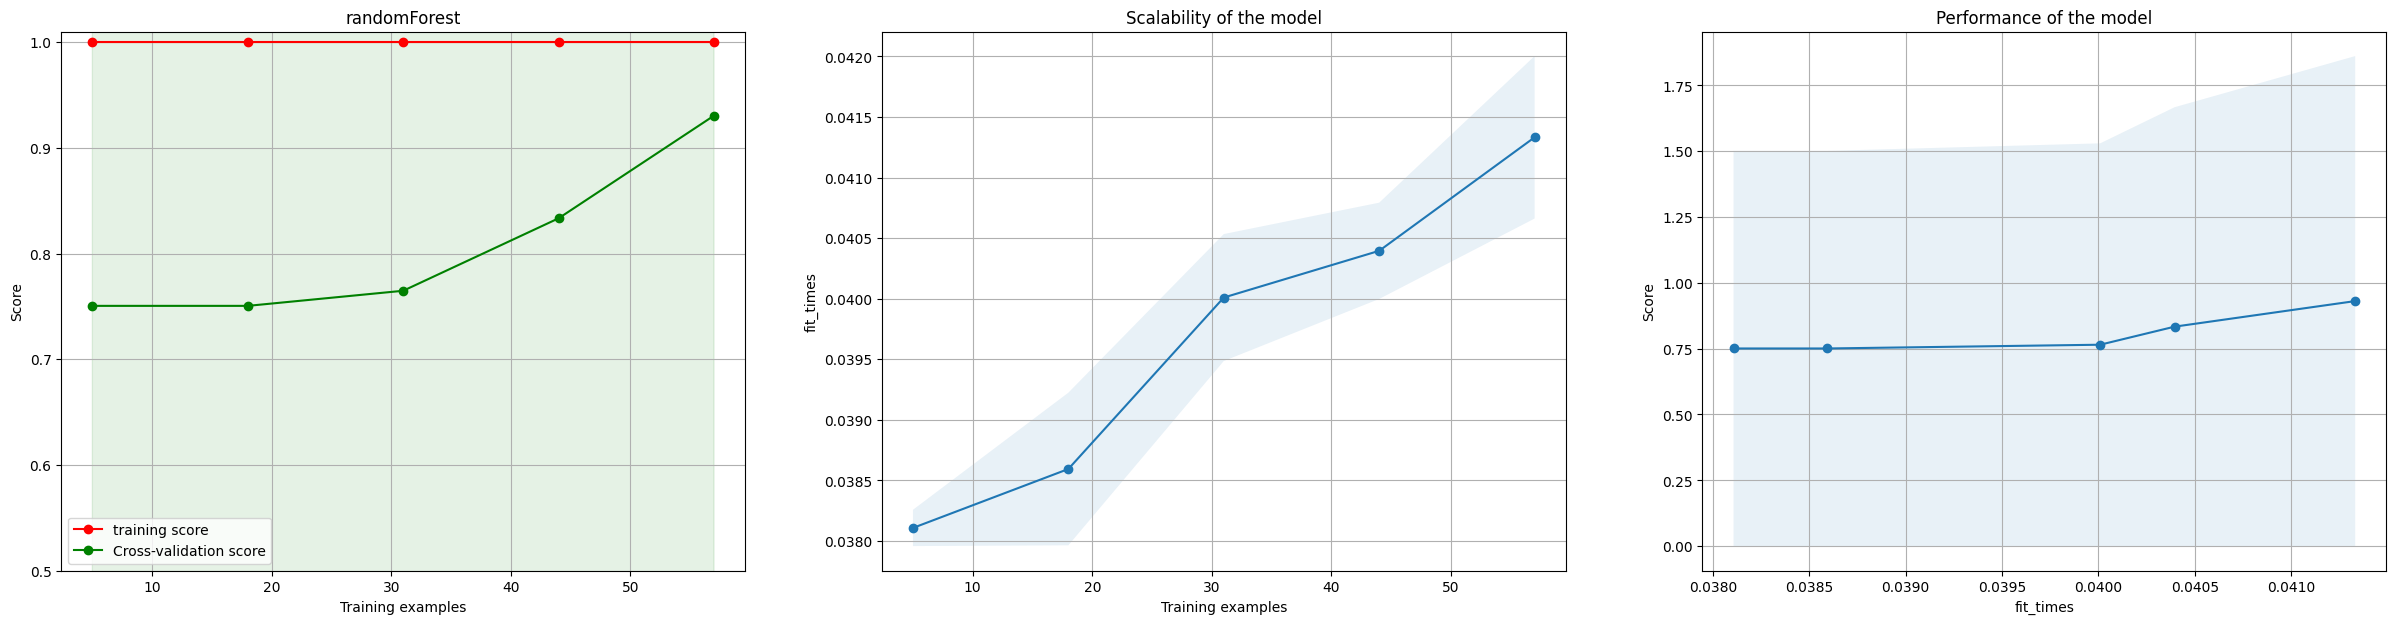

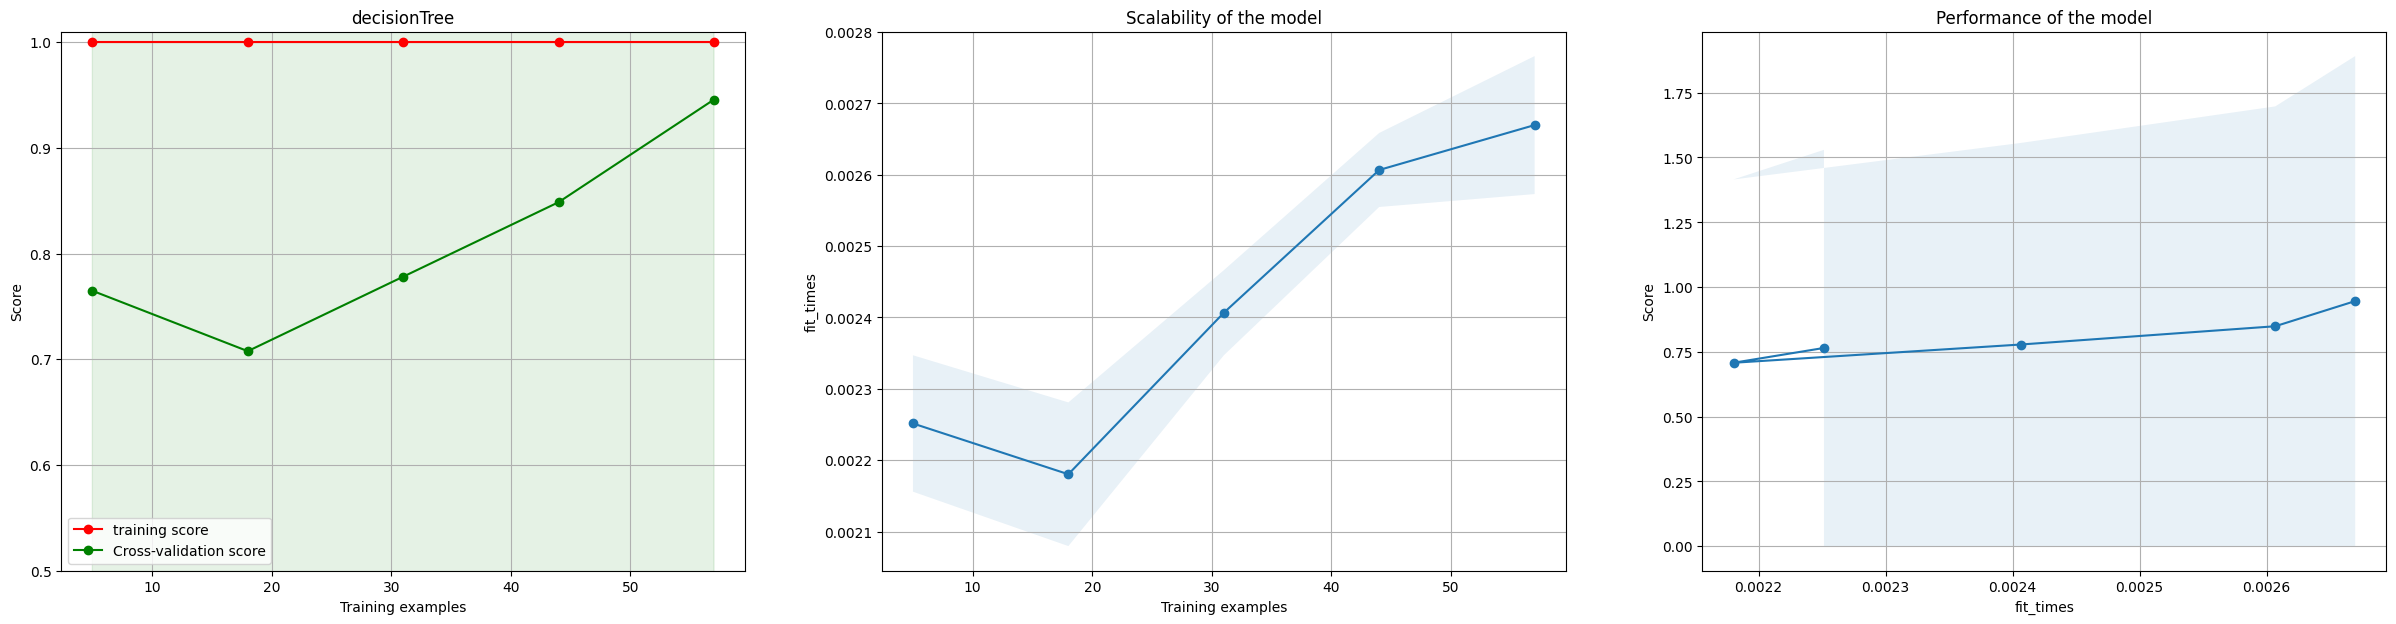

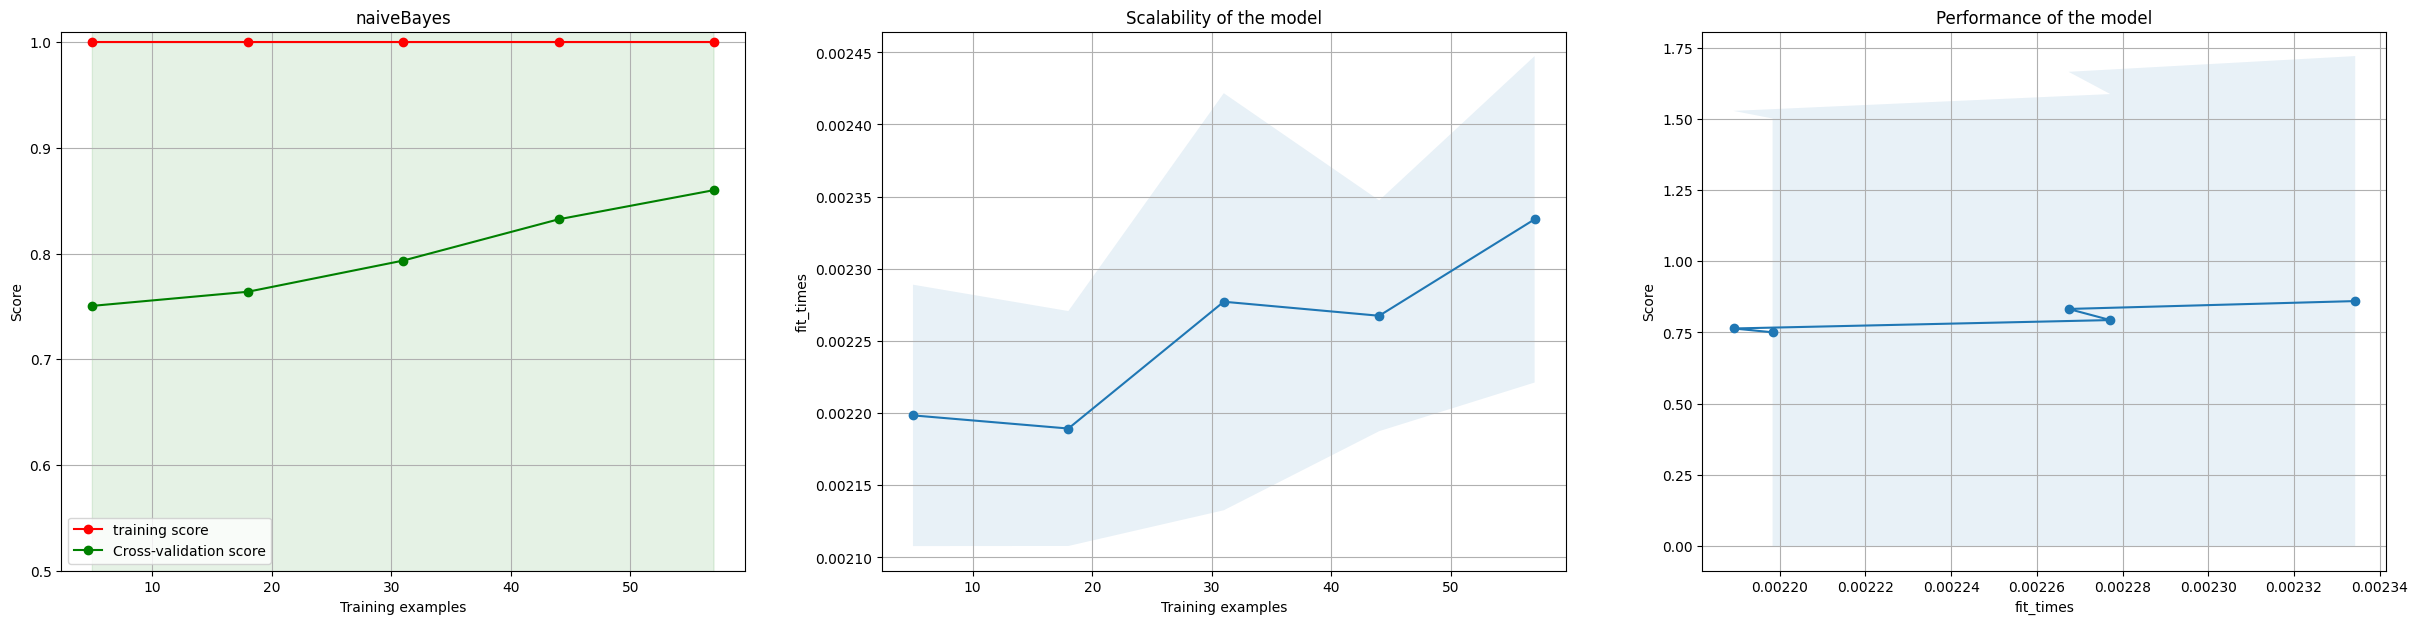

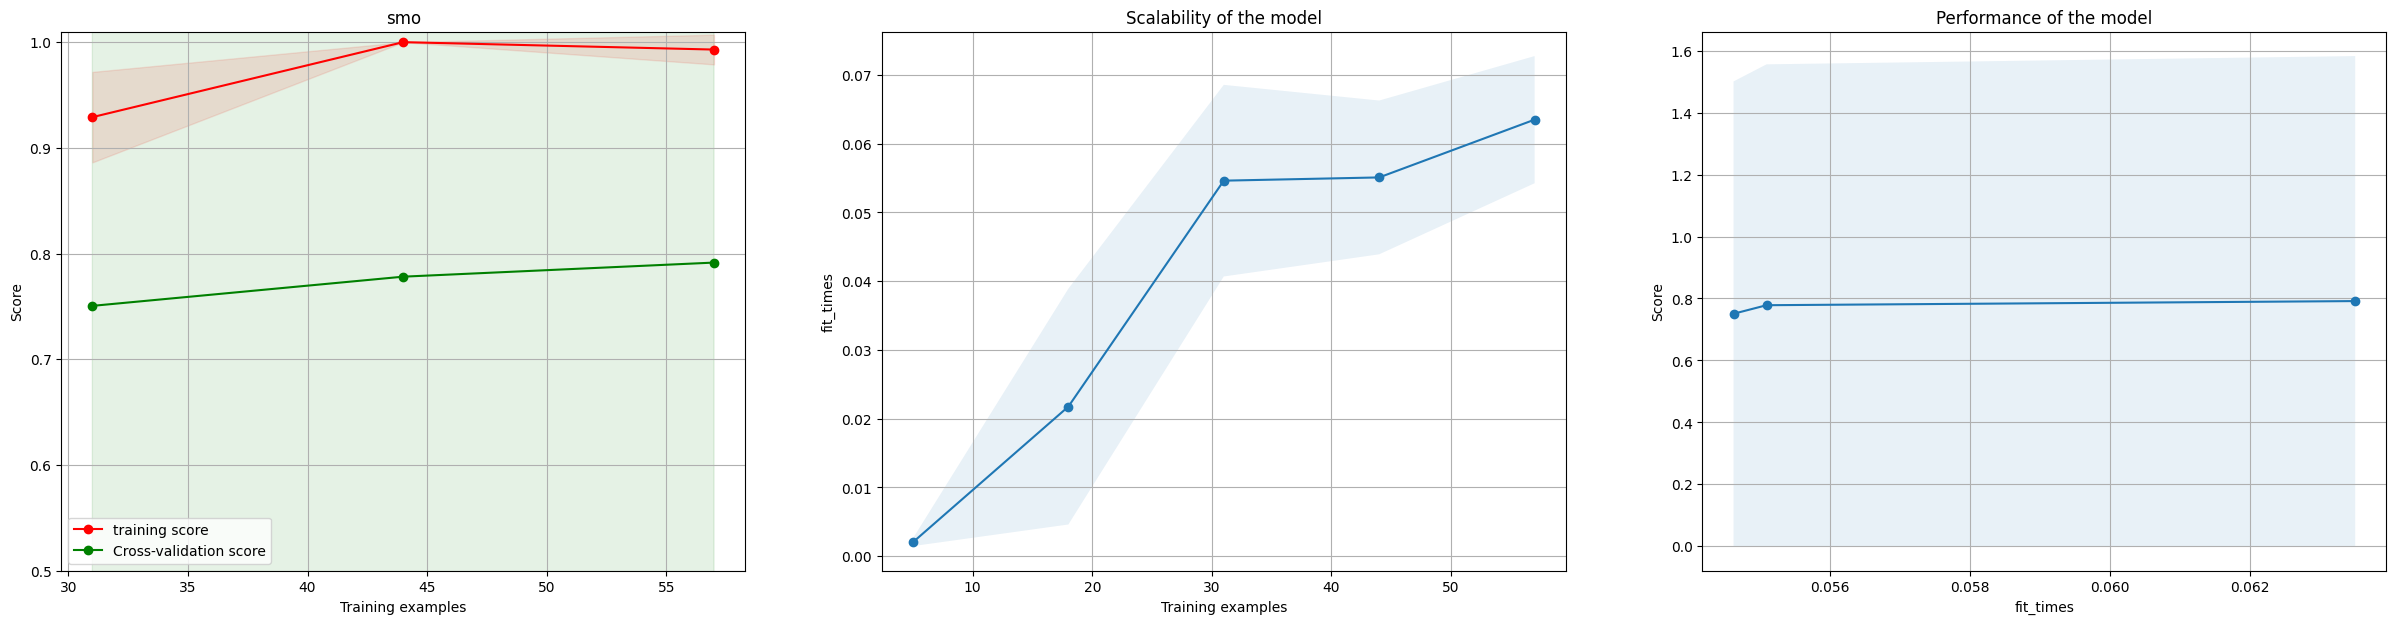

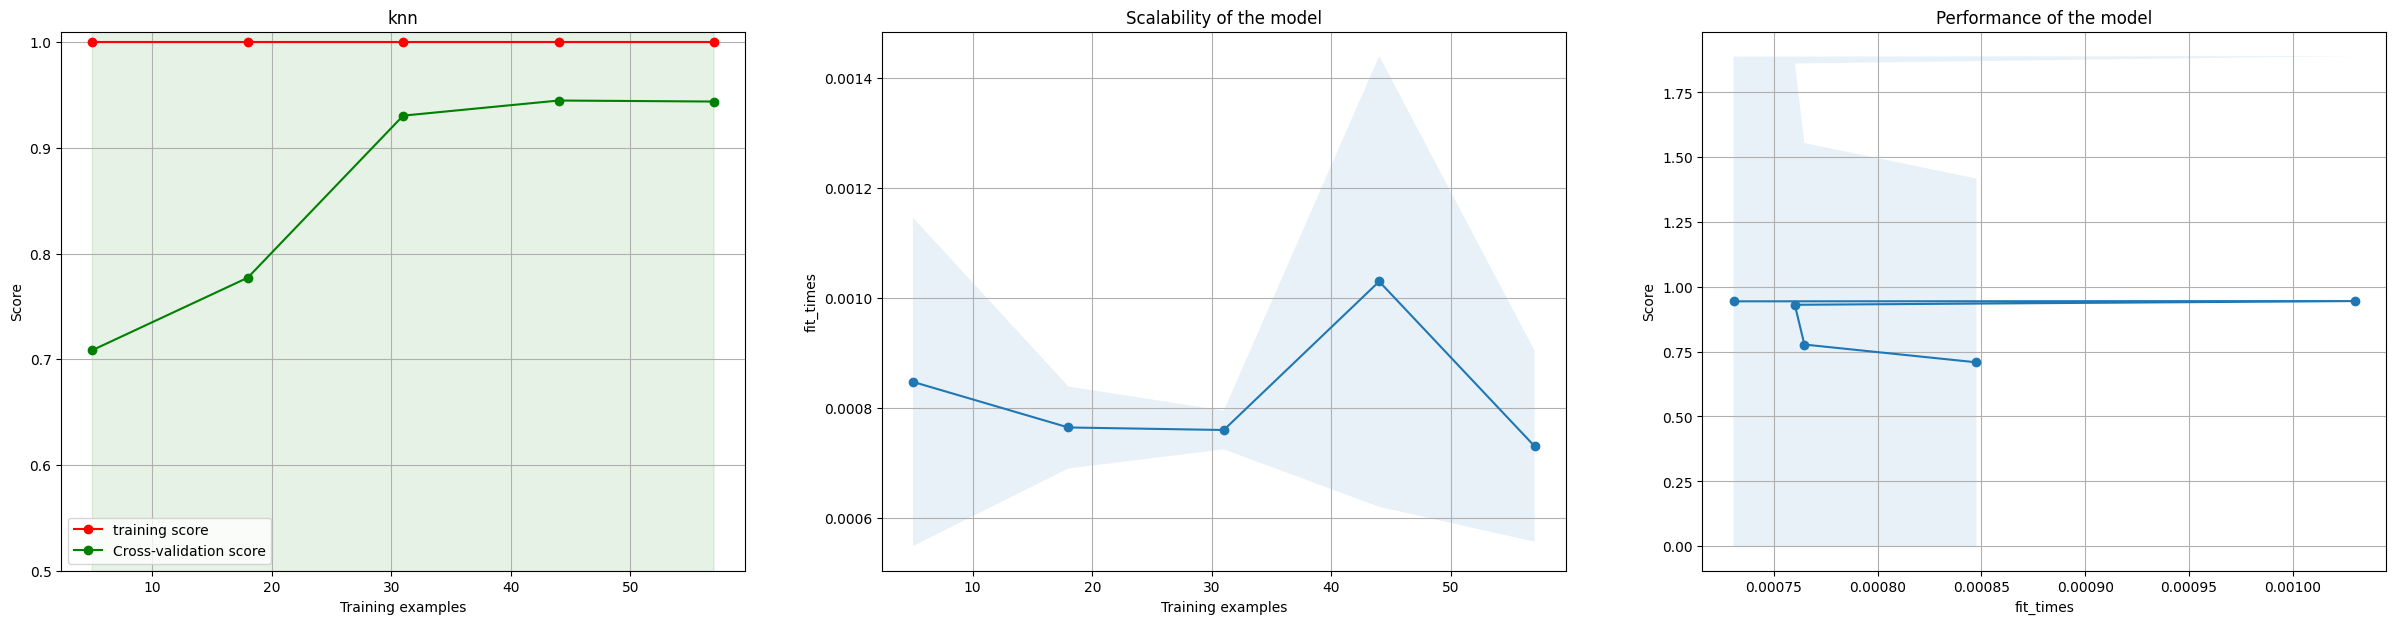

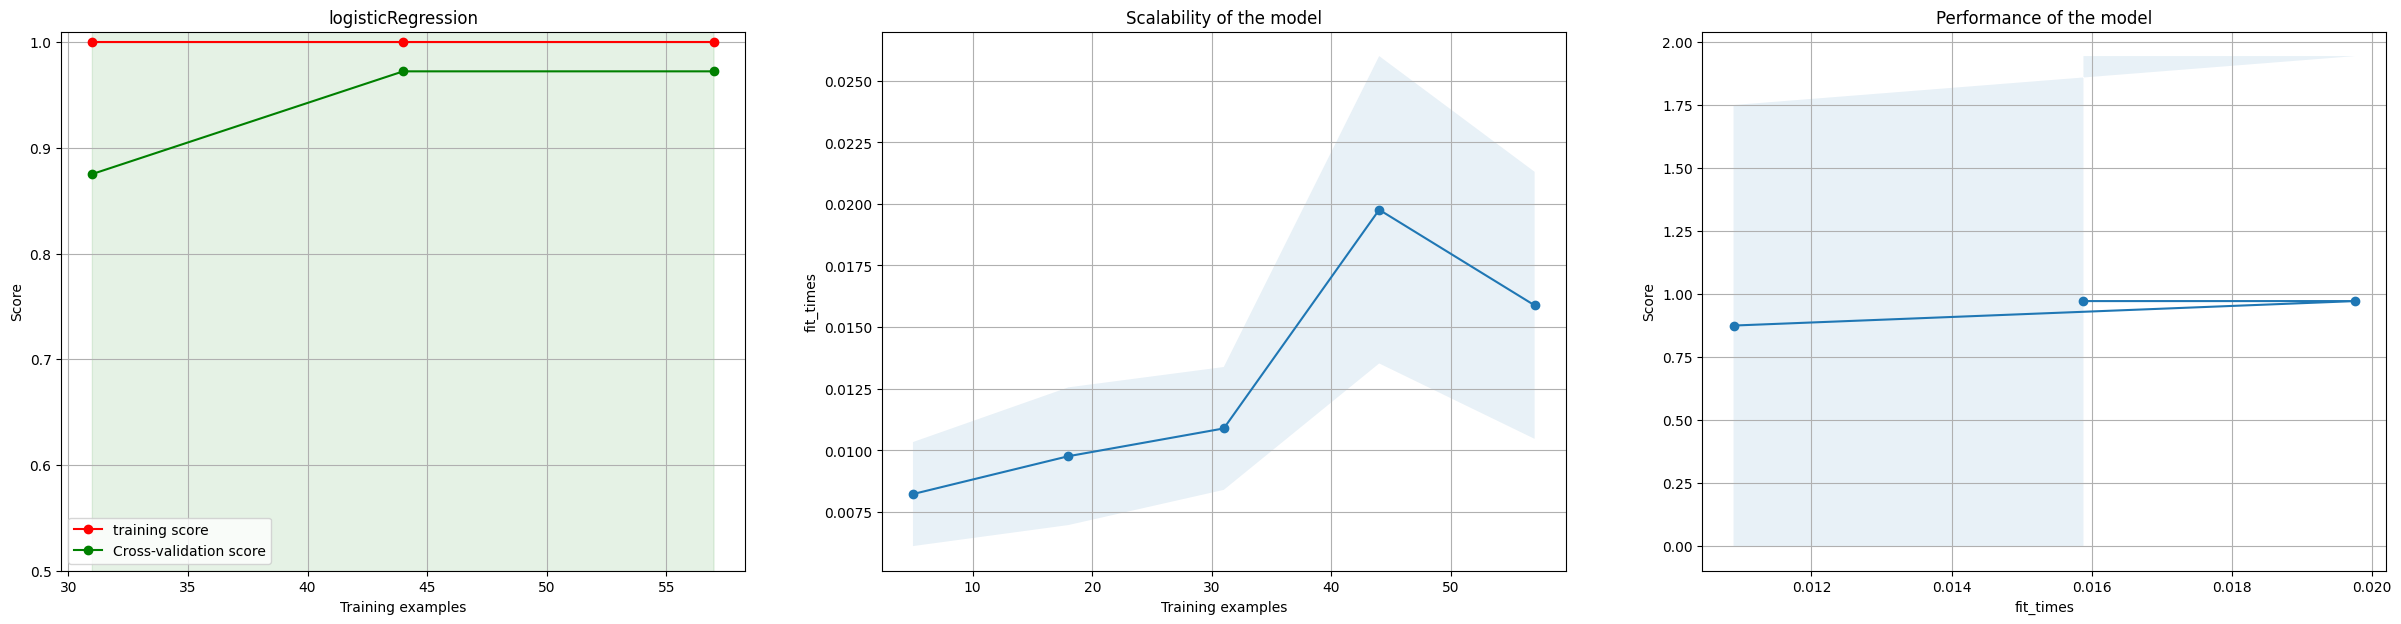

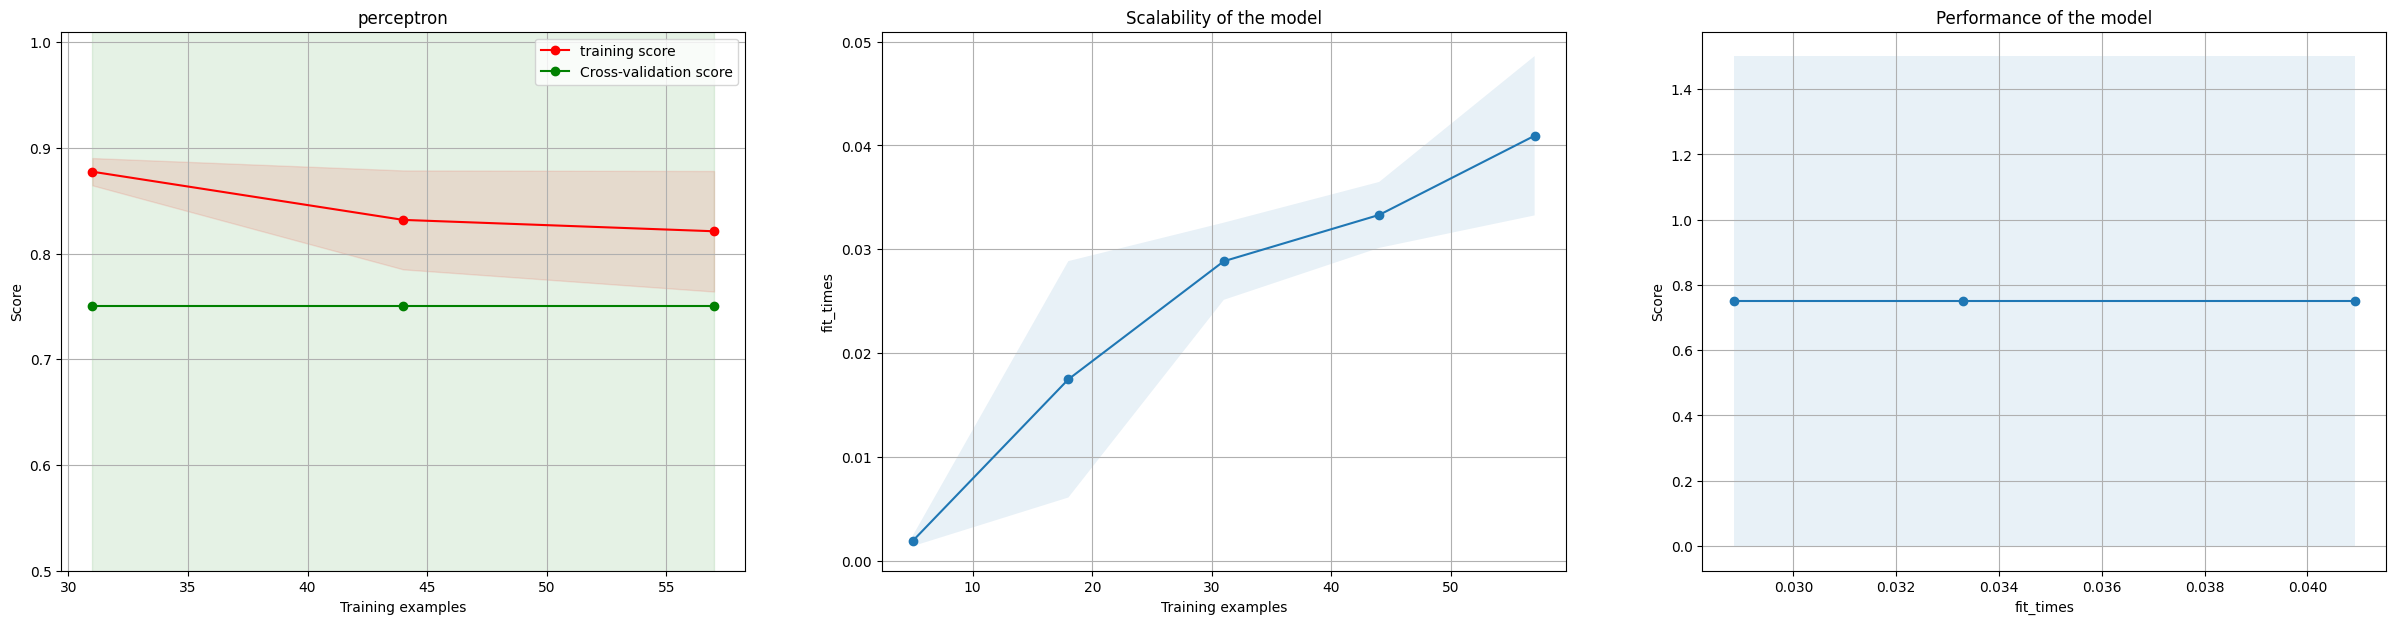

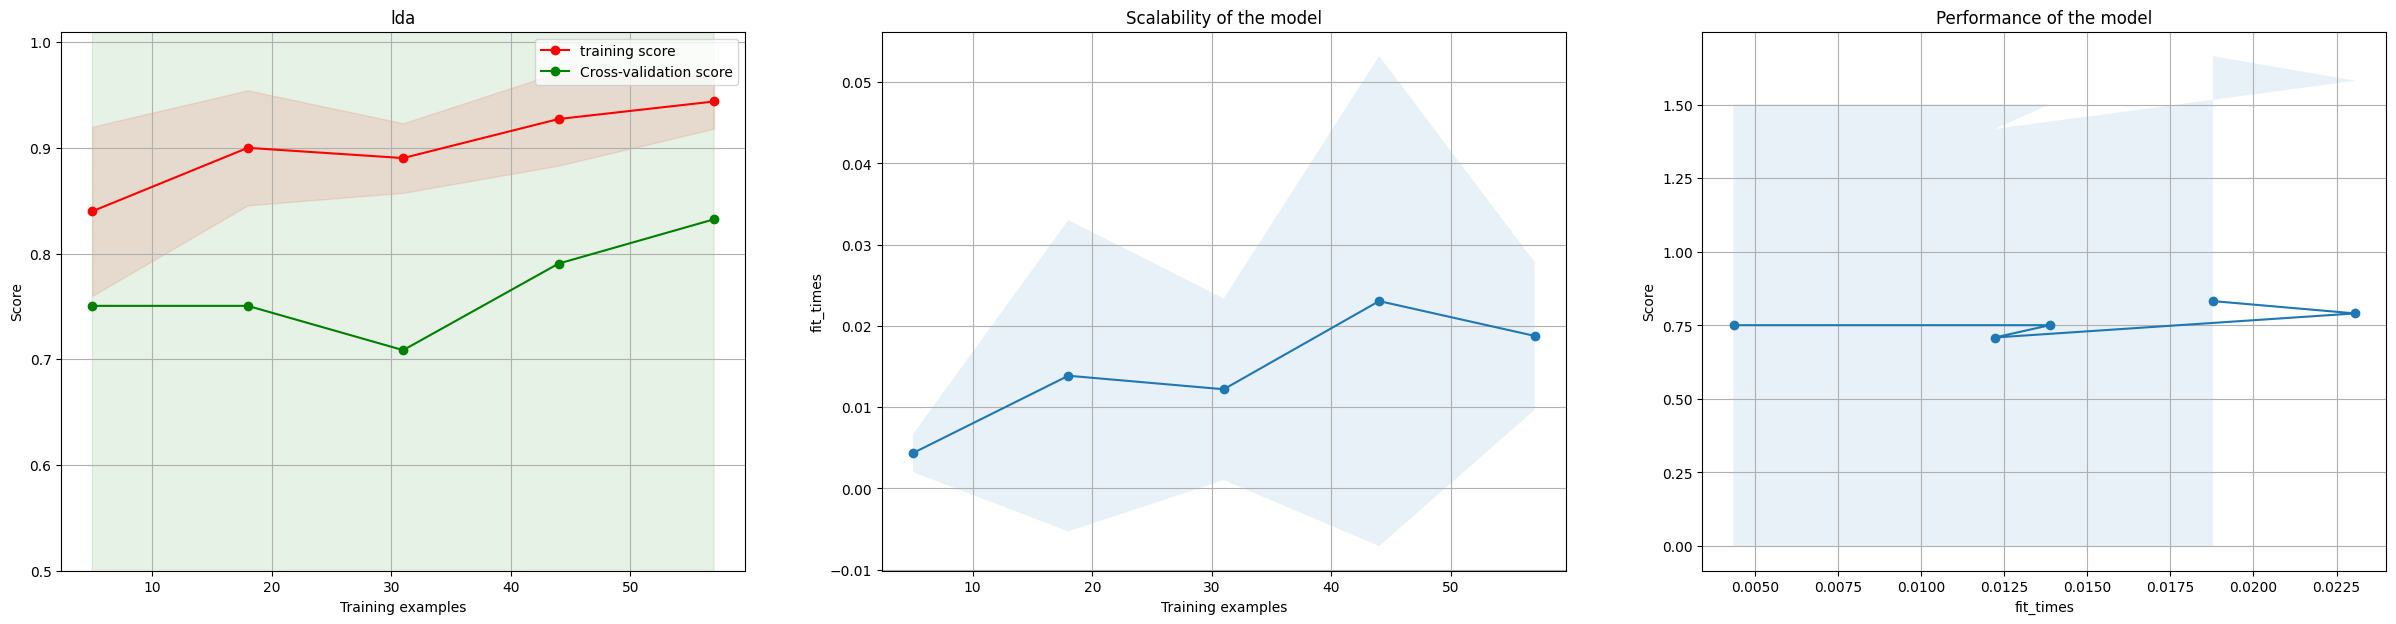

In [17]:
start_time = 0
results, res, classification_report = classify(x_train, x_test, y_train, y_test, classifiers, normalize=['knn'])




In [18]:
# y_train[y_train == 'Flaky'] = 1
# y_train[y_train == 'NonFlaky'] = 0

In [19]:
importance = feature_importance(x_train, y_train)
print("The top 20 features in Python Projects are:\n", x_train.columns[np.argsort(-importance)[:20]])

The top 20 features in Python Projects are:
 Index(['func', 'clock', 'time', 'pod', 'new', 'assert', 'require', 'should',
       'map', 'true', 'async', 'if', 'error', 'string', 'sleep', 'ginkgo',
       'poll', 'subjects', 'err', 'up'],
      dtype='object')


In [20]:
print(classification_report)

{'precision': 0.2857142857142857, 'recall': 1.0, 'f1-score': 0.4444444444444445, 'support': 2.0}


In [21]:
print(results.confusionMatrix)

0    [[2, 0], [0, 16]]
1    [[2, 0], [1, 15]]
2    [[2, 0], [0, 16]]
3    [[2, 0], [0, 16]]
4    [[2, 0], [0, 16]]
5    [[2, 0], [0, 16]]
6    [[0, 2], [0, 16]]
7    [[2, 0], [5, 11]]
Name: confusionMatrix, dtype: object


In [22]:
results.to_excel('./go_results.xlsx', index=False)
